In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [ ]:
data.head()

> El objetivo es predecir el retraso de llegada

In [ ]:
target.describe()

> El objetivo es predecir el retraso de llegada

# Training error vs testing error

In [ ]:
# Con un DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

In [ ]:
# Después de entrenar el regresor, nos gustaría saber su generalización potencial
# rendimiento una vez implementado en producción.
# Para este propósito, usamos el error absoluto medio,
# lo que nos da un error en la unidad nativa.

from sklearn.metrics import mean_absolute_error, r2_score

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
r2 = r2_score(target, target_predicted)
print('Nuestro regresor hace:')
print(f"mean_absolute_error de {score:.2f}")
print(f"r2 de {r2:.2f}")

La evaluación más básica implica:
- dividir nuestro conjunto de datos en dos subconjuntos: un conjunto de entrenamiento y un conjunto de prueba;
- ajuste del modelo en el conjunto de entrenamiento;
- estimar el error de entrenamiento en el conjunto de entrenamiento;
- estimar el error de prueba en el conjunto de prueba.

In [ ]:
# dividimos nuestro conjunto de datos.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [ ]:
# entrenamos nuestro modelo.

regressor.fit(data_train, target_train)

In [ ]:
# Finalmente, estimamos los diferentes tipos de errores.
# el error de entrenamiento.

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"El error de entrenamiento es {score:.2f}")

In [ ]:
# el error de prueba.

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"El error de prueba es {score:.2f}")

# Estabilidad de las estimaciones de validación cruzada
La **validación cruzada** permite estimar la **robustez de un modelo predictivo** repitiendo el procedimiento de división. Dará varios errores de entrenamiento y prueba y, por lo tanto, alguna estimación de la variabilidad del rendimiento de generalización del modelo.

Existen diferentes estrategias de validación cruzada, por ahora nos vamos a centrar en una llamada **“shuffle-split”**. En cada iteración de esta estrategia:
- mezclar aleatoriamente el orden de las muestras de una copia del conjunto de datos completo;
- dividir el conjunto de datos barajados en un tren y un conjunto de prueba;
- entrenar un nuevo modelo en el juego de trenes;
- evaluar el error de prueba en el equipo de prueba.

Repetimos este procedimiento n_splits veces. Hay que tener en cuenta que el coste computacional aumenta con n_splits.

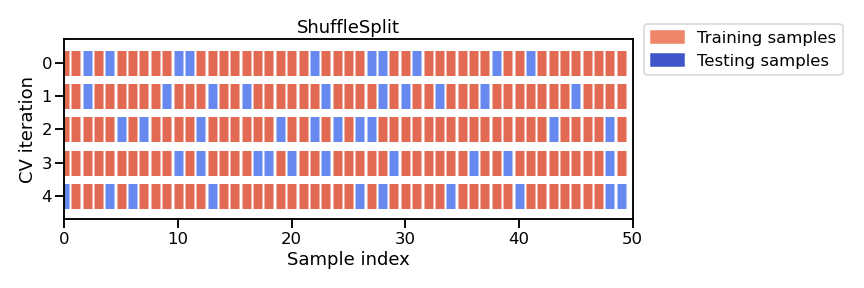

En este caso estableceremos n_splits=40, lo que significa que entrenaremos 40 modelos en total y todos serán descartados: solo registramos su **desempeño de generalización en cada variante del conjunto de prueba**.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [ ]:
# Los resultados cv_results se almacenan en un diccionario Python.
# Lo convertiremos en un marco de datos de pandas para facilitar la visualización y manipulación.

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

In [ ]:
# revertimos los negativos
cv_results["test_error"] = -cv_results["test_score"]

# verificamos los resultados
cv_results.head(10)

In [ ]:
len(cv_results)

In [ ]:
# Obtenemos 40 entradas en nuestro marco de datos resultante porque realizamos 40 divisiones.
# Por lo tanto, podemos mostrar la distribución del error de prueba y así tener una estimación de su variabilidad.

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [ ]:
print(f"La media del cross-validated testing error es: "
      f"{cv_results['test_error'].mean():.2f}")

In [ ]:
print(f"La desviación estandar del testing error es: "
      f"{cv_results['test_error'].std():.2f}")

In [ ]:
# Tracemos la distribución de la variable target

target.plot.hist(edgecolor="black")
plt.xlabel("Median ArrDelay")
_ = plt.title("Target distribution")

In [ ]:
print(f"La desviación estándar del target es: {target.std():.2f}")

In [ ]:
# En el caso de que solo esté interesado en el score de la prueba,
# scikit-learn proporciona la función cross_val_score.
# Es idéntico a llamar a la función cross_validate y seleccionar solo test_score.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores